# The One Goal for Today

To understand ROC curves and AUC.

In [1]:
import numpy as np
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

I am going to go back to the spam/ham dataset from Wednesday so that we can get a better understanding of ROC curves.

## I. Load and Look at our data

Let's load and __look at our data__. 

In [2]:
data = np.array(np.genfromtxt('data/SMSSpamCollection', delimiter='\t', encoding='utf-8', dtype=str))  
print(data.shape)

(5574, 2)


## II. Split the data

Let's split the data into train and test. 

When we check by printing shapes and unique values, does everything look okay?

In [3]:
train_data, test_data = np.split(data, [int(.8 * len(data))])
print(train_data.shape, test_data.shape)
print(np.unique(train_data[:, 0], return_counts=True))
print(np.unique(test_data[:, 0], return_counts=True))

(4459, 2) (1115, 2)
(array(['ham', 'spam'], dtype='<U910'), array([3857,  602]))
(array(['ham', 'spam'], dtype='<U910'), array([970, 145]))


## III. Preprocess the data

On Wednesday we tokenized the data and extracted counts for each token for each class ourselves.

Today I'm going to use two scikit-learn utilities:

CountVectorizer - will tokenize and count
LabelEncoder - will map the string labels to ints

As on Wednesday, I use *only the training data* to extract my token vocabulary.

In [4]:
# this tokenizes and makes the count table
vectorizer = CountVectorizer(lowercase=True, analyzer='word', max_features=1000)
vectorizer.fit(iter(train_data[:, 1]))

# this encodes the training, dev and test data using the count table
# We have to use np.asarray because sklearn 1.0 doesn't want matrices for naive Bayes
train_processed = np.asarray(vectorizer.transform(iter(train_data[:, 1])).todense())
test_processed = np.asarray(vectorizer.transform(iter(test_data[:, 1])).todense())

# this encodes the labels into numbers
encoder = LabelEncoder()
encoder.fit(train_data[:, 0])
train_labels = encoder.transform(train_data[:, 0])
test_labels = encoder.transform(test_data[:, 0])

## IV. Fit, Predict and Score

Today I'm going to compare the performance of several scikit-learn Naive Bayes alternatives on this dataset. These variations on Naive Bayes model different *probability distributions* over the training data, rather than using the likelihoods and priors directly.

Although we aren't using our own, hand-written Naive Bayes, you can see that the pattern is the same:
1. Fit
2. Predict
3. Score

With respect to "score", you'll see we are calculating:
* precision
* recall
* F1

*per class*. 

Let's make a different version of the confusion matrix focusing on just the 'spam' class, which is the class we really want to do well on:

| | Predict not in 'spam' | Predict in 'spam' | Rates |
| -- | --- | --- | -- |
| Actual not in 'spam' | TN (ham/ham) | FP (ham/spam) | FPR = FP/(FP+TN) |
| Actual in 'spam' | FN (spam/ham) | TP (spam/spam) | TPR = TP/(TP+FN) |

| | Predict not in 'ham' | Predict in 'ham' | Rates |
| -- | --- | --- | -- |
| Actual not in 'ham' | TN (spam/spam) | FP (spam/ham) | FPR = FP/(FP+TN) |
| Actual in 'ham' | FN (ham/spam) | TP (ham/ham) | TPR = TP/(TP+FN) |

With a table like this, we can calculate:
* Precision (how many of those we guessed were 'spam' were actually 'spam'?): TP / (TP + FP)
* Recall (how many actual 'spam' did we guess were 'spam'?): TP / (TP + FN)

Then, to get an assessment of recall and precision together, we can calculate F1: (2\*Precision\*Recall)/(Precision+Recall)

Today, we depict the confusion matrix using a heatmap, for variety.

Q: *What is a situation in which you might prefer to know P/R/F1 instead of accuracy, or where accuracy might be misleading?*

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       970
        spam       0.93      0.95      0.94       145

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[959  11]
 [  7 138]]


<AxesSubplot: >

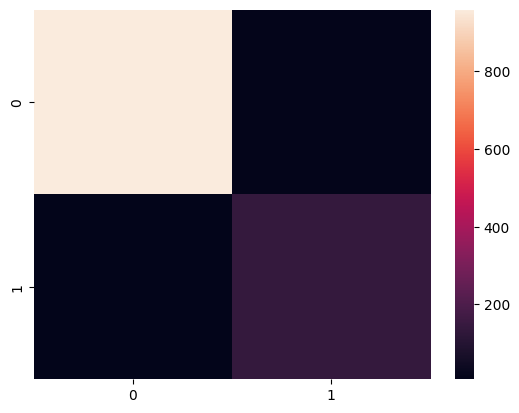

In [5]:
nb = MultinomialNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(test_processed)
print(classification_report(test_labels, pred, target_names=encoder.classes_))
print(confusion_matrix(test_labels, pred))
sns.heatmap(confusion_matrix(test_labels, pred))

## ROC Curve; AUC

We can also plot the **ROC curve** and calculate **AUC**.
* ROC - receiver operating characteristic curve, constructed by plotting the TPR against the FPR
* AUC - area under the ROC curve

Here is a good introduction to these: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/

We will plot the ROC curve using sklearn.

In [7]:
nb.predict_proba(test_processed)

array([[9.99064095e-01, 9.35905033e-04],
       [9.29788037e-11, 1.00000000e+00],
       [1.00000000e+00, 8.04493964e-14],
       ...,
       [9.99813223e-01, 1.86777412e-04],
       [9.99999993e-01, 7.07951510e-09],
       [9.97712504e-01, 2.28749622e-03]])

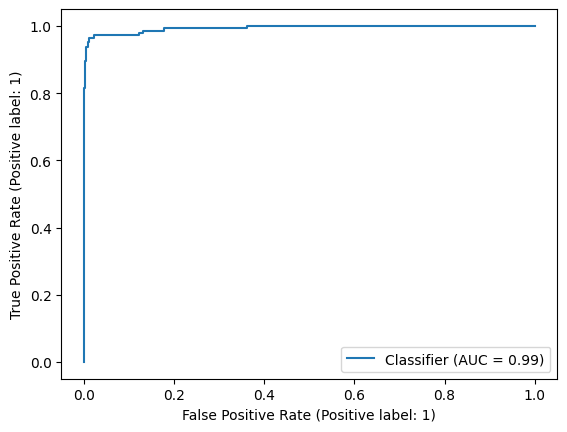

In [6]:
RocCurveDisplay.from_predictions(test_labels, nb.predict_proba(test_processed)[:, 1])

Let's take a closer look at those predictions. We will call predict_proba instead of predict. This will give us the *probabilities* the naive Bayes classifier uses to determine the best class. So for each data point, we will have the probability of ham and the probability of spam. 

Q: *Are these the prior, likelihood, normalization or posterior probabilities?*

In [ ]:
pred_with_probs = nb.predict_proba(test_processed)
print(pred_with_probs)

By default, we take the label with the maximum probability, right? However, you can see that one way we could "adjust" the classifier is to set a threshold for making a decision; so for example, it's not spam unless the probability of spam is at least 60%.

Q: *What would be the effect of setting that 60% threshold?*

The ROC curve plots the FPR (x axis) against the TPR (y axis). 

Q: *What do FPR and TPR stand for, again?*

So the ROC curve illustrates the thresholds that are available to us, and the consequences if we choose a different threshold.

Now, AUC is the area under that curve.

Q: *If AUC is 1, then what can we say about the model?*

Q: *If AUC is 0, then what can we say about the model?*

Quite often, you will see a ROC curve plotted against a diagonal line as in 

![this example from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/de/ROC_curve.svg)

Q: *What does the diagonal line denote?*

              precision    recall  f1-score   support

         ham       0.99      0.76      0.86       970
        spam       0.37      0.94      0.54       145

    accuracy                           0.79      1115
   macro avg       0.68      0.85      0.70      1115
weighted avg       0.91      0.79      0.82      1115



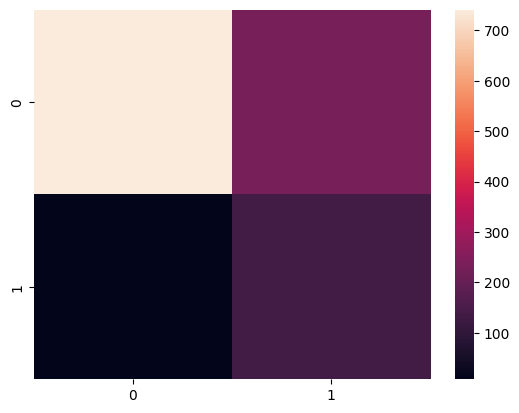

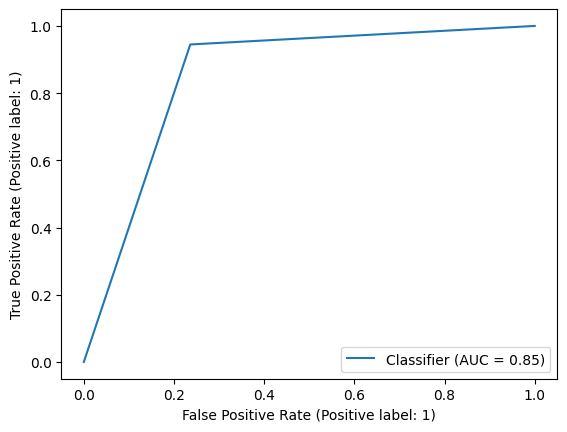

In [8]:
nb = GaussianNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(test_processed)
print(classification_report(test_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(test_labels, pred))
RocCurveDisplay.from_predictions(test_labels, nb.predict_proba(test_processed)[:, 1])

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       970
        spam       0.82      0.97      0.89       145

    accuracy                           0.97      1115
   macro avg       0.91      0.97      0.94      1115
weighted avg       0.97      0.97      0.97      1115



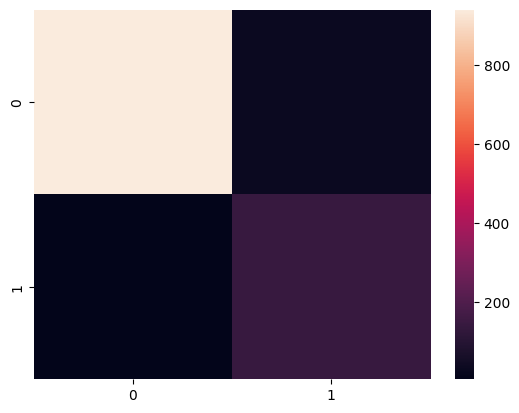

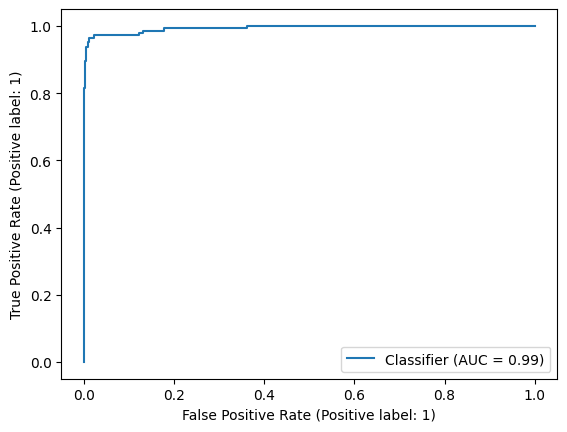

In [9]:
nb = ComplementNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(test_processed)
print(classification_report(test_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(test_labels, pred))
RocCurveDisplay.from_predictions(test_labels, nb.predict_proba(test_processed)[:, 1])

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       970
        spam       0.99      0.92      0.95       145

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



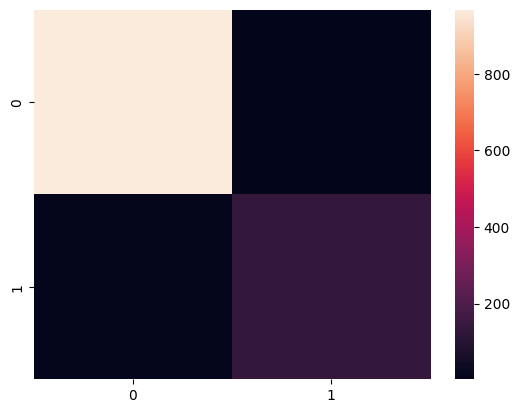

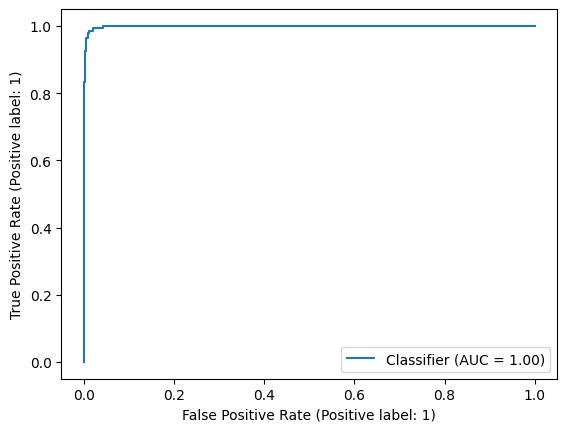

In [10]:
nb = BernoulliNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(test_processed)
print(classification_report(test_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(test_labels, pred))
RocCurveDisplay.from_predictions(test_labels, nb.predict_proba(test_processed)[:, 1])

Q. *Looking at these ROC curves and AUC scores, which model would you choose? Why? Does your choice correspond to the model with highest accuracy?*

You *can* plot ROC curves for multiclass classifiers, but you have to do it one label at a time, either:
* one versus rest - assume this class is "positive" and all the other datapoints are "negative"
* one versus one - compare pairs of labels

## V. Resources

* https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f
* https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
* https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a